In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [2]:
# Paquetes del tio guapo
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

In [3]:
# Cosas Enric
from tensorflow.keras.layers import LSTM, Masking
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
# Use Tensorboard for network visualization & debugging
from tensorflow.keras.callbacks import TensorBoard
import sklearn.metrics
# import regularizer(s)
from tensorflow.keras.regularizers import l1, l2, l1_l2
# import Dropout
from tensorflow.keras.layers import Dropout
# import activation seperately
from tensorflow.keras.layers import Activation

## Import the  non standarized data

In [4]:
V52 = pd.read_csv('V52_data_no_standarized.csv')

V52 = V52.drop(columns=['Date'])
V52 = V52.rename(columns={'Unnamed: 0': 'Date'})
V52['Date'] = pd.to_datetime(V52['Date'])
V52 = V52.set_index('Date')

## AVOID NaNs.... (Hablar con enrique)

In [104]:
# just take the longest continuous data from V52_data

longest_sequence = 0
current_sequence = 0
start_index = None
end_index = None
current_start_index = None

for i, value in enumerate(V52['Wsp_44m']):
    if pd.notna(value):
        if current_sequence == 0:
            current_start_index = i
        current_sequence += 1
    else:
        if current_sequence > longest_sequence:
            longest_sequence = current_sequence
            start_index = current_start_index
            end_index = i - 1
        current_sequence = 0

# Check for the last sequence in case it reaches the end of the column
if current_sequence > longest_sequence:
    longest_sequence = current_sequence
    start_index = current_start_index
    end_index = len(V52) - 1

print("Longest sequence without NaN values:", longest_sequence)
print("Start index:", start_index)
print("End index:", end_index)

# Create a new dataframe with the longest sequence
V52_data_longest = V52.iloc[start_index:end_index+1]



Longest sequence without NaN values: 1346
Start index: 28435
End index: 29780


In [98]:
# Just take out NaN from V52
V52_no_nan = V52.dropna(axis=0, how='any', inplace=False)

## Split the data into train and test

In [116]:
train_size = int(len(V52_no_nan) * 0.8)
test_size = len(V52_no_nan) - train_size

train, test = V52_no_nan.iloc[0:train_size], V52_no_nan.iloc[train_size:len(V52_no_nan)]


print(train.shape, test.shape)

(29686, 10) (7422, 10)


## Scale the data

Enrique.... si puedes pensar una manera mejor seria la polla

In [117]:
from sklearn.preprocessing import RobustScaler

# packag for ignore warnings
import warnings
warnings.filterwarnings('ignore')

f_colums = ['ActPow', 'ActPow_std']    # X columns
 
# For easy standardization of the data
f_transformer = RobustScaler()
power_transformer = RobustScaler()


# Transform the train and test
f_transformer = f_transformer.fit(train[f_colums].to_numpy())  # Fit for standardization of X
power_transformer = power_transformer.fit(train[['ActPow']])   # Fit for standardization of Y

# Apply to the train and test
train.loc[:, f_colums] = f_transformer.transform(train[f_colums].to_numpy())
train['ActPow'] = power_transformer.transform(train[['ActPow']])

test.loc[:, f_colums] = f_transformer.transform(test[f_colums].to_numpy())
test['ActPow'] = power_transformer.transform(test[['ActPow']])

## Divide the data into Sequences

In [118]:
# Cutting of the time series into sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
       v = X.iloc[i: (i + time_steps)].to_numpy()
       Xs.append(v)
       ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# We are creating the sequences for the time step defined

In [119]:
TIME_STEPS = 144 # Venga lets take a hole day

# Now create the acrual training and test sequences

X_train, y_train = create_sequences(train[['ActPow', 'ActPow_std']], train['ActPow'], time_steps=TIME_STEPS)
X_test, y_test = create_sequences(test[['ActPow', 'ActPow_std']], test['ActPow'], time_steps=TIME_STEPS)

In [120]:
# Print the shape to see if everything is ok
# [samples, time_steps, n_features]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(29542, 144, 2) (29542,)
(7278, 144, 2) (7278,)


## TUFFE MODEL - FOLLOWING VIDEO STEPS

## MODEL CREATION

In [121]:
pad_value = 999
no_features = 2

model = Sequential()

# Masking layer (for the pad_value)
model.add(Masking(mask_value=pad_value, input_shape=(None, no_features)))

# First LSTM layer with L2 regularization
model.add(LSTM(50,
               return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2]),
               kernel_initializer='random_uniform',
               bias_initializer='zeros',
               kernel_regularizer=l2(0.01),  # L2 regularization
               dtype='float32'))

# Activation layer
model.add(Activation('relu'))


# Second LSTM layer with L2 regularization
model.add(LSTM(10,
               activation='relu',
               kernel_regularizer=l2(0.01),  # L2 regularization
               dtype='float32'))


# Output Layer
model.add(Dense(1, activation='linear'))

In [122]:
# comile the model to be ready for training
model.compile(loss='mean_squared_error', optimizer='adam')

## RUN THE MODEL

In [123]:
history = model.fit(
                    X_train, y_train, 
                    epochs=30,
                    batch_size=300,
                    validation_split = 0.2,  # para validar el modelo sin utilizar los datos de train
                    shuffle=False
                     )

Epoch 1/30
79/79 [==============================] - 25s 281ms/step - loss: 1485429932032.0000 - val_loss: 0.9793
Epoch 2/30
79/79 [==============================] - 22s 277ms/step - loss: 0.8769 - val_loss: 0.8756
Epoch 3/30
79/79 [==============================] - 22s 276ms/step - loss: 0.8054 - val_loss: 0.8230
Epoch 4/30
79/79 [==============================] - 22s 283ms/step - loss: 0.7618 - val_loss: 0.7857
Epoch 5/30
79/79 [==============================] - 22s 282ms/step - loss: 0.7314 - val_loss: 0.7580
Epoch 6/30
79/79 [==============================] - 22s 276ms/step - loss: 0.7099 - val_loss: 0.7374
Epoch 7/30
79/79 [==============================] - 22s 280ms/step - loss: 0.6953 - val_loss: 0.7228
Epoch 8/30
79/79 [==============================] - 23s 289ms/step - loss: 0.6862 - val_loss: 0.7139
Epoch 9/30
79/79 [==============================] - 22s 276ms/step - loss: 0.6804 - val_loss: 0.7083
Epoch 10/30
79/79 [==============================] - 22s 274ms/step - loss: 0.6

## PLOT THE LOST

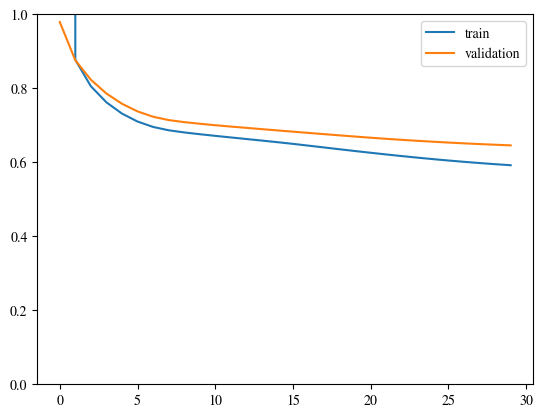

In [125]:
# plot the lost
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 1)
plt.legend()

# SEE HOW PREDICTIONS MATCH THE REAL DATA

In [126]:
# see some predictions
y_pred = model.predict(X_test)

# Des normalize the data (ENRIQUEEEE HAZLOOOO TU)

228/228 [==============================] - 5s 18ms/step


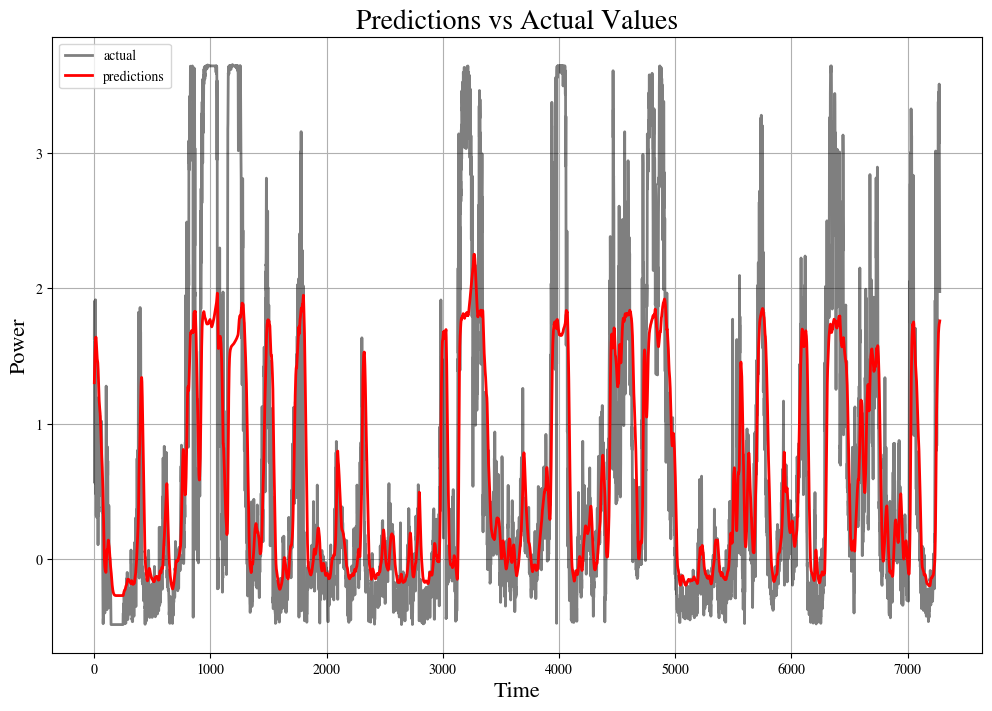

In [127]:

# plot the predictions
plt.figure(figsize=(12,8))

plt.plot(y_test, 'k',label='actual', linewidth=2, alpha=0.5)
plt.plot(y_pred,'-r', label='predictions', linewidth=2)
plt.grid(True)

plt.title('Predictions vs Actual Values', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Power', fontsize=16)

plt.legend()

# Idea: we are going to make dayly seqquences. Whenver thre is a NaN in that day we discard that day

In [5]:
# add a column with day and month
V52['day'] = V52.index.day
V52['month'] = V52.index.month

# Descart the last day of V52
V52 = V52[:-1]

# Group by day and month
V52_day_month = V52.groupby(['day', 'month'])

In [170]:
# Extract the group corresponding to the first day
first_day_group = V52_day_month.get_group((1, 1))


print(first_day_group.shape)  # 144 values for each column and 12 atributtes

(144, 12)


In [6]:
# Define the number of days in each month
days_in_month = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

day_nan = {}
for m in range(1, 13):  # Loop through all months
    for d in range(1, days_in_month[m] + 1):  # Loop through all days in the current month
        # Check if in the days there are some missing values in the actPow
        day = V52_day_month.get_group((d, m))
        nan_count = day['ActPow'].isna().sum()
        day_nan[(d, m)] = nan_count  # Store the count of NaNs for this day and month, or 0 if there are no NaNs

In [7]:
day_month_without_nan = []
for m in range(1, 13):  # Loop through all months
    for d in range(1, days_in_month[m] + 1):  # Loop through all days in the current month
        if day_nan[(d, m)] == 0:  # If there are NaNs in this day
        
        # Store the day and the month
            day_month_without_nan.append((d, m))         

## Create the train sequences

In [10]:
# Train sequence is going to be the longest sequence without NaNs
# Validation sequence is going to be the second longest sequence without NaNs
# Test sequence is going to be the third longest sequence without NaNs

# Evething can be obtain from the day_month_without_nan list

def get_longest_sequences(day_month):
    sequences = [[day_month[0]]]  # List of all sequences
    for i in range(1, len(day_month)):
        # Check if the current day is the next day in the sequence
        if (day_month[i][0] == sequences[-1][-1][0] + 1 and day_month[i][1] == sequences[-1][-1][1]) or (day_month[i][0] == 1 and day_month[i][1] == sequences[-1][-1][1] + 1):
            sequences[-1].append(day_month[i])
        else:
            # If it's not, start a new sequence
            sequences.append([day_month[i]])
    # Sort the sequences by length in descending order
    sequences.sort(key=len, reverse=True)
    # Return the three longest sequences
    return sequences[:3]



In [11]:
longest_sequences = get_longest_sequences(day_month_without_nan)
longest_sequence = longest_sequences[0]
second_longest_sequence = longest_sequences[1]
third_longest_sequence = longest_sequences[2]

print("Longest sequence:", longest_sequence)
print("Second longest sequence:", second_longest_sequence)
print("Third longest sequence:", third_longest_sequence)

Longest sequence: [(18, 7), (19, 7), (20, 7), (21, 7), (22, 7), (23, 7), (24, 7), (25, 7)]
Second longest sequence: [(28, 11), (29, 11), (1, 12), (2, 12), (3, 12), (4, 12), (5, 12)]
Third longest sequence: [(27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (1, 2)]


In [17]:
# Train sequence -> longest sequence
# Validation sequence -> second longest sequence
# Test sequence -> third longest sequence

# From V52, take the data having the month and the day from the longest sequence
month = longest_sequence[0][1]
days = [day[0] for day in longest_sequence]

validation = V52[(V52['month'] == month) & (V52['day'].isin(days))]

# From V52, take the data having the month and the day from the second longest sequence
month = second_longest_sequence[0][1]
days = [day[0] for day in second_longest_sequence]

train = V52[(V52['month'] == month) & (V52['day'].isin(days))]

# From V52, take the data having the month and the day from the third longest sequence
month = third_longest_sequence[0][1]
days = [day[0] for day in third_longest_sequence]

test = V52[(V52['month'] == month) & (V52['day'].isin(days))]

# STANDARDIZE THE DATA and CREATE THE SEQUENCES Xtrain and Ytrain, Xtest and Ytest and Xval and Yval

In [19]:
# standardize the data only take the actPow and actPow_std
f_colums = ['ActPow', 'ActPow_std']    # X columns

# manually (x - mean) / std and save the mean and std for later
train_mean = train[f_colums].mean()
train_std = train[f_colums].std()

train.loc[:, f_colums] = (train[f_colums] - train_mean) / train_std

# Test
test_mean = test[f_colums].mean()
test_std = test[f_colums].std()

test.loc[:, f_colums] = (test[f_colums] - test_mean) / test_std

# Validation
validation_mean = validation[f_colums].mean()
validation_std = validation[f_colums].std()

validation.loc[:, f_colums] = (validation[f_colums] - validation_mean) / validation_std

In [21]:
from sklearn.preprocessing import RobustScaler

# packag for ignore warnings
import warnings
warnings.filterwarnings('ignore')

f_colums = ['ActPow', 'ActPow_std']    # X columns
 
# For easy standardization of the data
f_transformer = RobustScaler()
power_transformer = RobustScaler()


# Transform the train and test
f_transformer = f_transformer.fit(train[f_colums].to_numpy())  # Fit for standardization of X
power_transformer = power_transformer.fit(train[['ActPow']])   # Fit for standardization of Y

# Apply to the train and test
train.loc[:, f_colums] = f_transformer.transform(train[f_colums].to_numpy())
train['ActPow'] = power_transformer.transform(train[['ActPow']])

test.loc[:, f_colums] = f_transformer.transform(test[f_colums].to_numpy())
test['ActPow'] = power_transformer.transform(test[['ActPow']])

validation.loc[:, f_colums] = f_transformer.transform(validation[f_colums].to_numpy())
validation['ActPow'] = power_transformer.transform(validation[['ActPow']])

In [22]:
# Okey now we can create the actual sequences
TIME_STEPS = 6 # Venga lets take half a day

# Now create the acrual training and test sequences

X_train, y_train = create_sequences(train[['ActPow', 'ActPow_std']], train['ActPow'], time_steps=TIME_STEPS)
X_test, y_test = create_sequences(test[['ActPow', 'ActPow_std']], test['ActPow'], time_steps=TIME_STEPS)
X_val, y_val = create_sequences(validation[['ActPow', 'ActPow_std']], validation['ActPow'], time_steps=TIME_STEPS)

NameError: name 'create_sequences' is not defined

## MODEL CREATION

In [203]:
pad_value = 999
no_features = 2

# for multiple model creation - clear  the previous DAG
K.clear_session() 


model = Sequential()

# Masking layer (for the pad_value)
model.add(Masking(mask_value=pad_value, input_shape=(None, no_features)))

# First LSTM layer with L2 regularization
model.add(LSTM(150,
               return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2]),
               kernel_initializer='random_uniform',
               bias_initializer='zeros',
            #    kernel_regularizer=l2(0.01),  # L2 regularization
               dtype='float32'))

# Activation layer
model.add(Activation('relu'))


# Second LSTM layer with L2 regularization
model.add(LSTM(20,
               activation='relu',
            #    kernel_regularizer=l2(0.01),  # L2 regularization
               dtype='float32'))


# Output Layer
model.add(Dense(1, activation='linear'))

In [204]:
# comile the model to be ready for training
model.compile(loss='mean_squared_error', optimizer='adam')

In [205]:
history = model.fit(
                    X_train, y_train, 
                    epochs=40,
                    batch_size=40,
                    validation_split = 0.1,  # para validar el modelo sin utilizar los datos de train
                    shuffle=False
                     )

Epoch 1/40
26/26 [==============================] - 4s 40ms/step - loss: 1.0869 - val_loss: 2.3328e-04
Epoch 2/40
26/26 [==============================] - 0s 8ms/step - loss: 0.9537 - val_loss: 1.7240e-04
Epoch 3/40
26/26 [==============================] - 0s 8ms/step - loss: 0.6968 - val_loss: 3.0696e-05
Epoch 4/40
26/26 [==============================] - 0s 8ms/step - loss: 0.4080 - val_loss: 7.5351e-05
Epoch 5/40
26/26 [==============================] - 0s 9ms/step - loss: 0.4548 - val_loss: 1.2799e-05
Epoch 6/40
26/26 [==============================] - 0s 9ms/step - loss: 0.4554 - val_loss: 1.8002e-06
Epoch 7/40
26/26 [==============================] - 0s 8ms/step - loss: 0.4951 - val_loss: 4.8361e-07
Epoch 8/40
26/26 [==============================] - 0s 8ms/step - loss: 0.3527 - val_loss: 6.4361e-05
Epoch 9/40
26/26 [==============================] - 0s 8ms/step - loss: 0.3194 - val_loss: 1.2274e-04
Epoch 10/40
26/26 [==============================] - 0s 8ms/step - loss: 0.3106 -

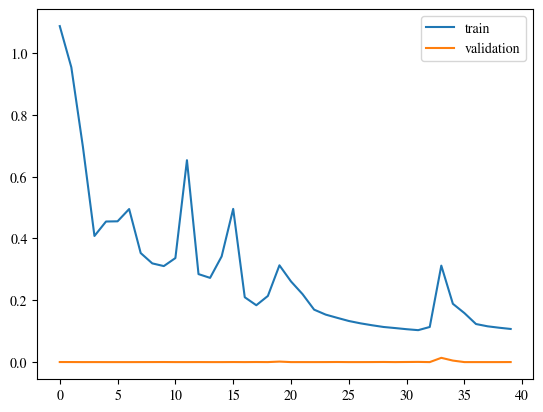

In [206]:
# plot the lost
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

27/27 [==============================] - 0s 5ms/step


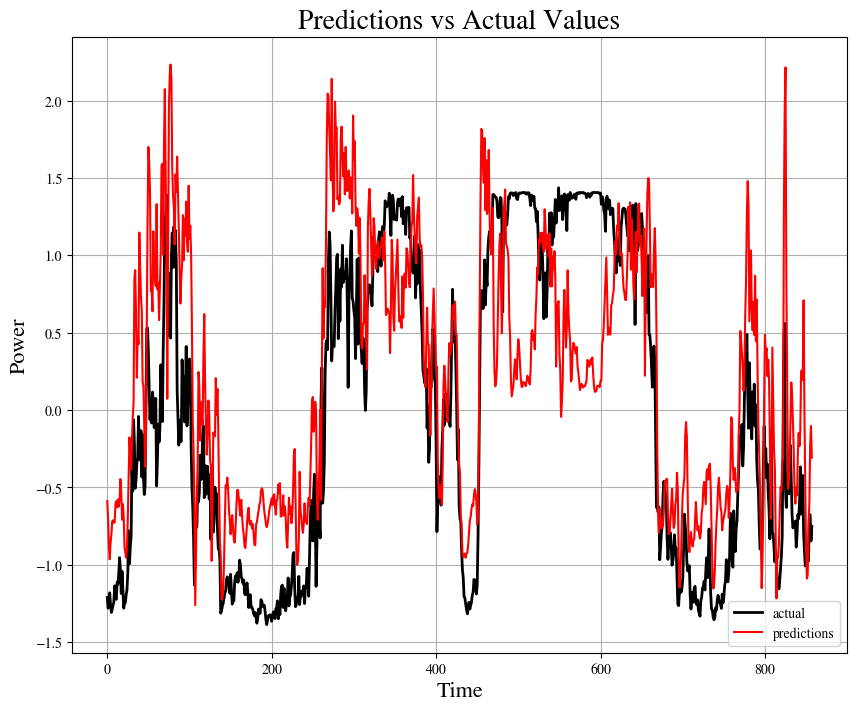

In [209]:
# see some predictions
y_pred = model.predict(X_val)

# des normalize the predictions
y_pred_des = y_pred * validation_std['ActPow'] + validation_mean['ActPow']

# plot the predictions
plt.figure(figsize=(10,8))

plt.plot(y_val, 'k', label='actual', linewidth=2)
plt.plot(y_pred,'-r', label='predictions', linewidth=1.5)
plt.grid(True)

plt.title('Predictions vs Actual Values', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Power', fontsize=16)

plt.legend()

In [191]:
# see if there is any nan i Xtest
np.isnan(X_val).any()

False